In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.2.0-rc4
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# 1. preprocessing data
# 2. build model
# 2.1 encoder
# 2.2 attention
# 2.3 decoder
# 3. evaluation
# 3.1 given sentence, return translated results
# 3.2 visualize results (attention)

In [4]:
en_spa_file_path = './data_spa_en/spa.txt'

import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

en_sentence = 'Why me?'
spa_sentence = '¿Por qué yo?'
print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(spa_sentence))


Why me?
¿Por que yo?


In [9]:
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([?.!,¿])",r" \1 ",s)
    s = re.sub(r'[" "]+'," ",s)
    s = re.sub(r'[^a-zA-Z?.!,¿]', " ",s)
    s = s.rstrip().strip()
    
    s = '<start> ' + s + ' <end>'
    return s

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(spa_sentence))

<start> why me ? <end>
<start> ¿ por que yo ? <end>


In [41]:
def parse_data(filename):
    lines = open(filename, encoding='UTF-8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    preprocessed_sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs
    ]
    print(preprocessed_sentence_pairs[0])
    return zip(*preprocessed_sentence_pairs)

en_dataset, sp_dataset = parse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])
print(len(en_dataset))

('<start> go . <end>', '<start> ve . <end>')
<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
118964


In [45]:
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, filters='',split=' '
    )
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[0:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[0:30000])


def max_length(tensor):
    return min(len(t) for t in tensor)

print(input_tensor[0])
max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)

print(max_length_input)
print(max_length_output)


[  1 135   3   2   0   0   0   0   0   0   0   0   0   0   0   0]
16
11


In [15]:
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor, output_tensor, test_size=0.2)

len(input_train), len(input_eval), len(output_train)

(24000, 6000, 24000, 6000)

In [29]:
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print('%d --> %s' % (t, tokenizer.index_word[t]))

convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)

1 --> <start>
37 --> tengo
11 --> que
7099 --> pintarlo
3 --> .
2 --> <end>

1 --> <start>
4 --> i
29 --> have
15 --> to
1343 --> paint
10 --> it
3 --> .
2 --> <end>


In [31]:
def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder = True)
    return dataset

batch_size = 64
epochs = 20

train_dataset = make_dataset(input_train, output_train, batch_size, epochs, True)
eval_dataset = make_dataset(input_eval, output_eval, batch_size, 1, False)





In [32]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)
    

(64, 16)
(64, 11)
tf.Tensor(
[[   1  451  229 ...    0    0    0]
 [   1   21 3802 ...    0    0    0]
 [   1    7   21 ...    0    0    0]
 ...
 [   1   22   33 ...    0    0    0]
 [   1   12  132 ...    0    0    0]
 [   1    8   35 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1    4  290    4   92  326    3    2    0    0    0]
 [   1    9 2522   49   56    3    2    0    0    0    0]
 [   1   10    8    9 1714    3    2    0    0    0    0]
 [   1   25    6   36  898    7    2    0    0    0    0]
 [   1   20   11   70   79  828    3    2    0    0    0]
 [   1    6   88  374    3    2    0    0    0    0    0]
 [   1   24   28   39    7    2    0    0    0    0    0]
 [   1    4   75   40  715  284    3    2    0    0    0]
 [   1   91  170  144    5    3    2    0    0    0    0]
 [   1   82   25   12   14   53    7    2    0    0    0]
 [   1    4   18  209  261   21  134    3    2    0    0]
 [   1    4   30   12  127 1578    3    2    0    0    0]
 [   1

In [48]:
embedding_units = 256
units = 1024
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1
print(input_vocab_size)

9414


In [49]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.encoding_units, return_sequences = True, return_state = True, 
                                    recurrent_initializer = 'glorot_uniform')
        
    def call(self, x, hidden):
        print(x.shape)
        x = self.embedding(x)
        print(x.shape)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)
print("sample_output.shape: ", sample_output.shape)
print("sample_hidden.shpae: ", sample_hidden.shape)

(64, 16)
(64, 16, 256)
sample_output.shape:  (64, 16, 1024)
sample_hidden.shpae:  (64, 1024)


In [72]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)

    def call(self, decoder_hidden, encoder_outputs):
        #decoder_hidden.shape: (batch_size, units)
        #encoder_outputs.shape: (batch_size, length, units)
#         print(decoder_hidden.shape)
#         print(encoder_outputs.shape)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
#         print(decoder_hidden_with_time_axis.shape)
#         print(self.W1(encoder_outputs).shape)
#         print(self.W2(decoder_hidden_with_time_axis).shape)
#         print((self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)).shape)
        #before V: (batch_size, length, units)
        #after V: (batch_size, length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
#         print(score.shape)
        #shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)
        # context_vector.shape: (batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
#         print(context_vector.shape)
        # context_vector.shape: (batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis = 1)
#         print(context_vector.shape)

        return context_vector, attention_weights

attention_model = BahdanauAttention(units=10)
context_vector, attention_weights = attention_model(sample_hidden, sample_output)

print("attention_results.shape: ", context_vector.shape)
print("attention_weights.shape: ", attention_weights.shape)


attention_results.shape:  (64, 1024)
attention_weights.shape:  (64, 16, 1)


In [73]:
t1 = tf.constant([[1,2,3],[4,5,6]])
t2 = tf.constant([[1,1,1]])
print(t1.shape)
print(t2.shape)

print(t1+t2)

(2, 3)
(1, 3)
tf.Tensor(
[[2 3 4]
 [5 6 7]], shape=(2, 3), dtype=int32)


In [75]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units, return_sequences = True, return_state = True, recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
        
    # x decoder当前步的输入
    def call(self, x, hidden, encoding_outputs):
        # context_vector.shape: (batch_size, units)
        context_vector, attention_weights = self.attention(hidden, encoding_outputs)
        
        # before embedding: x.shape: (batch_size, 1)
        # after embedding: x.shape: (batch_size, 1, embedding_units)
        x = self.embedding(x)
        
        combined_x = tf.concat([tf.expand_dims(context_vector, 1),x], axis = -1)
        
        #output.shape: [batch_size, 1, decoding_units]
        #state.shape: [batch_size, decoding_units]
        output, state = self.gru(combined_x)
        
        #output.shape: [batch_size, decoding_units]
        output = tf.reshape(output, (-1, output.shape[2]))
        
        output = self.fc(output)
        
        return output, state, attention_weights
    
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)
decoder_output, decoder_hidden, attention_weights = decoder(tf.random.uniform((batch_size, 1)),
                                          sample_hidden,
                                          sample_output)

print(decoder_output.shape)
print(decoder_hidden.shape)
print(attention_weights.shape)


(64, 4935)
(64, 1024)
(64, 16, 1)


In [77]:
optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')
def loss_function(real, predict):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, predict)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [78]:
@tf.function
def train_step(input, target, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(input, encoding_hidden)
        decoding_hidden = encoding_hidden
        
        # <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
        for t in range(0, target.shape[1]-1):
            decoding_input = tf.expand_dims(target[:, t], 1)
            predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(target[:, t+1], predictions)
    batch_loss = loss / int(target.shape[0])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [80]:
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size

for epoch in range(epochs):
    start = time.time()
    
    embedding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (input, target)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(input, target, embedding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1, batch, batch_loss.numpy()))
    
    print('Epoch {} Loss {:.4f}'.format(epoch+1, total_loss / steps_per_epoch))
    print('Time take for 1 epoch {} sec\n'.format(time.time()-start))

(64, 16)
(64, 16, 256)
(64, 16)
(64, 16, 256)
Epoch 1 Batch 0 Loss 0.7662
Epoch 1 Batch 100 Loss 0.3795
Epoch 1 Batch 200 Loss 0.3122
Epoch 1 Batch 300 Loss 0.3042
Epoch 1 Batch 400 Loss 0.2550
Epoch 1 Loss 0.3281
Time take for 1 epoch 216.32872986793518 sec

Epoch 2 Batch 0 Loss 0.2325
Epoch 2 Batch 100 Loss 0.2255
Epoch 2 Batch 200 Loss 0.2121
Epoch 2 Batch 300 Loss 0.1853
Epoch 2 Batch 400 Loss 0.1512
Epoch 2 Loss 0.1992
Time take for 1 epoch 206.54196286201477 sec

Epoch 3 Batch 0 Loss 0.1308
Epoch 3 Batch 100 Loss 0.1470
Epoch 3 Batch 200 Loss 0.1154
Epoch 3 Batch 300 Loss 0.1246
Epoch 3 Batch 400 Loss 0.0756
Epoch 3 Loss 0.1211
Time take for 1 epoch 206.98694396018982 sec

Epoch 4 Batch 0 Loss 0.0711
Epoch 4 Batch 100 Loss 0.0804
Epoch 4 Batch 200 Loss 0.0919
Epoch 4 Batch 300 Loss 0.0847
Epoch 4 Batch 400 Loss 0.0497
Epoch 4 Loss 0.0742
Time take for 1 epoch 206.9731936454773 sec

Epoch 5 Batch 0 Loss 0.0409
Epoch 5 Batch 100 Loss 0.0440
Epoch 5 Batch 200 Loss 0.0559
Epoch 5 Bat

In [92]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    input_sentence = preprocess_sentence(input_sentence)
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen = max_length_input, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    results = ''
    encoding_hidden = tf.zeros((1, units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    
    # eg: <start> -> A
    # A -> B -> C -> D
    
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
    
    for t in range(max_length_output):
        predictions, decoding_hidden, attention_weights = decoder(decoding_input, decoding_hidden, encoding_outputs)
        # attention.shape: (batch_size, input_length, 1) (1, 16, 1)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_matrix[t] = attention_weights.numpy()
        
        #predictions.shape: (batch_size, vocab_size) (1,4935)
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        results += output_tokenizer.index_word[predicted_id]+' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id], 0)
    
    return results, input_sentence, attention_matrix
    
def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap='viridis')
    
    font_dict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + input_sentence, fontdict = font_dict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict = font_dict, )
    plt.show()
    
def translate(input_sentence):
    results, input_sentence, attention_matrix  = evaluate(input_sentence)
    
    print("Input: %s " % (input_sentence))
    print("Predicted translation: %s" %(results))
    
    attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))
    
    
    

(1, 16)
(1, 16, 256)
Input: <start> ¿ quien eres ? <end> 
Predicted translation: who are you ? <end> 


c:\users\86188\tensor_keras\lib\site-packages\ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\users\86188\tensor_keras\lib\site-packages\ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


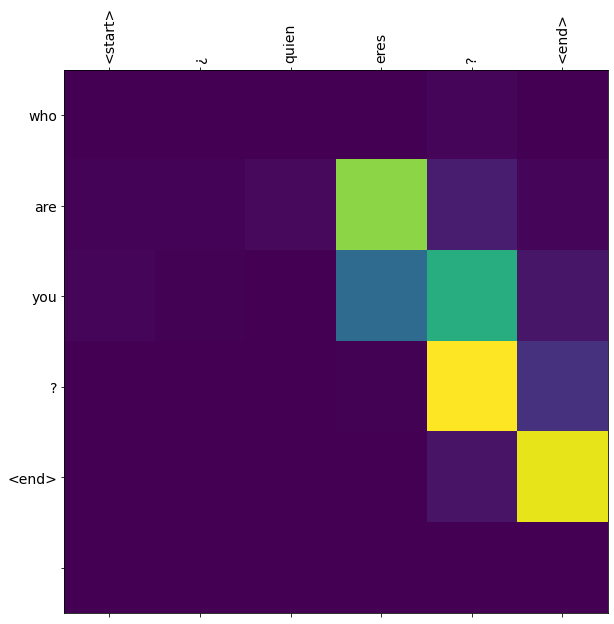

In [102]:
translate('¿Quién eres?')